In [1]:
##複素エンコーダ

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import pandas as pd

In [3]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data', 'MNIST_AE[9]_rep_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1024
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/MNIST_AE[9]_rep_result


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [5]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [7]:
#Encoder7
class Encoder(nn.Module):
    def __init__(self,num_in,num_out,En_lay,alpha=0.6):
        super(Encoder, self).__init__()

        in_features = num_in
        self.B_matrices = []

        if En_lay>1:
            for _ in range(En_lay-1):            
                mid_features = in_features-int((num_in-num_out)/En_lay)
                real_part = torch.randn(mid_features, in_features)*(1/np.sqrt(in_features))
                imag_part = torch.randn(mid_features, in_features)*(1/np.sqrt(in_features))
                B = torch.complex(real_part, imag_part).detach().to(device)
                B.requires_grad = False
                self.B_matrices.append(B)
                in_features = mid_features
        
        real_part = torch.randn(num_out, in_features)*(1/np.sqrt(in_features))
        imag_part = torch.randn(num_out, in_features)*(1/np.sqrt(in_features))
        B = torch.complex(real_part, imag_part).detach().to(device)
        B.requires_grad = False
        self.B_matrices.append(B)

        self.alpha = alpha
    
    def forward(self, x):
        for B in self.B_matrices:
            x = torch.exp(1j * self.alpha * x) #e^(iαx)
            x = x.T
            x = torch.matmul(B, x)
            x = x.T
        x = torch.abs(x) ** 2
        
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out,De_lay,act_fun):
        super(Decoder, self).__init__()
        decoder_layers = []
        in_features = num_in

        act_fun_dict = {
        1: nn.ReLU(),
        2: nn.LeakyReLU(),
        3: nn.Tanh(),
        4: nn.ELU()
        }
        sel_act_fun = act_fun_dict.get(act_fun, nn.ReLU)

        for _ in range(De_lay-1):
            mid_features = in_features+int((num_out-num_in)/De_lay)
            decoder_layers.append(nn.Linear(in_features,mid_features))
            decoder_layers.append(sel_act_fun)
            in_features = mid_features

        decoder_layers.append(nn.Linear(in_features,num_out))
        decoder_layers.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers)


    def forward(self, x):

        x = self.decoder(x)

        return x

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self,num_IN,num_N,En_lay,De_lay,act_fun):
        super(AutoEncoder, self).__init__()


        self.encoder = Encoder(num_IN,num_N,En_lay)

        self.decoder = Decoder(num_N, num_IN,De_lay,act_fun)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.encoder(x) 
        
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [10]:
#MNISTのイメージを表示するやつ
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] ##
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

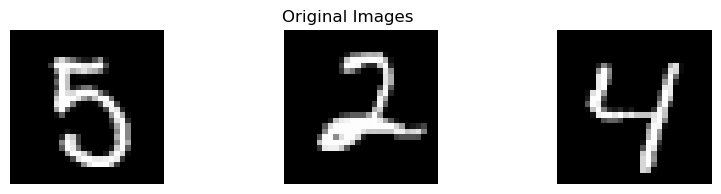

In [11]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:##
        break
show_images(test_images, test_labels,"Original Images")
file_name = 'originalMNISTimage(524).png'
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

EncoderLayers:1 DecoderLayers:2 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0074,loss_test: 0.0070


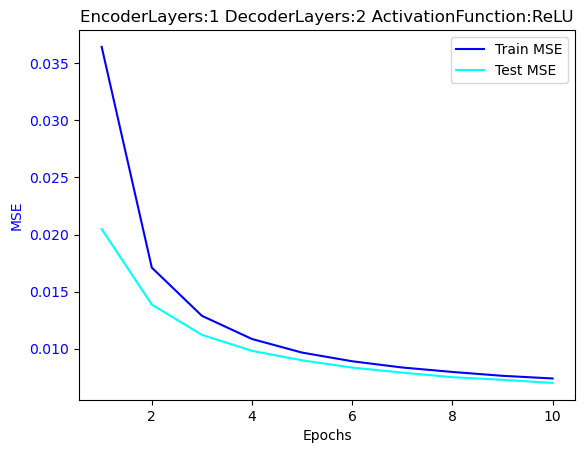

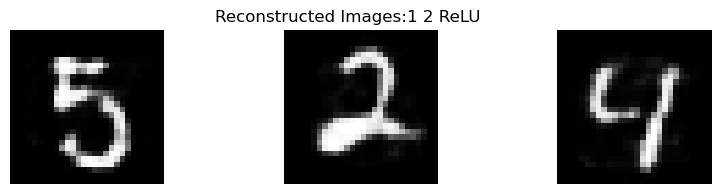

EncoderLayers:1 DecoderLayers:2 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0071,loss_test: 0.0067


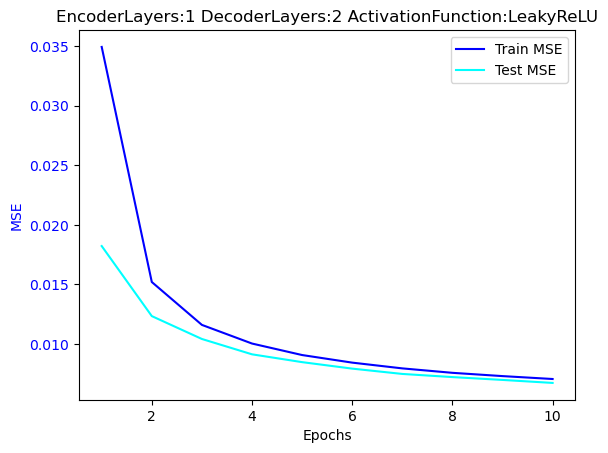

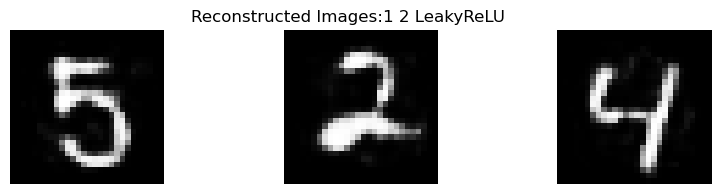

EncoderLayers:1 DecoderLayers:2 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0068,loss_test: 0.0066


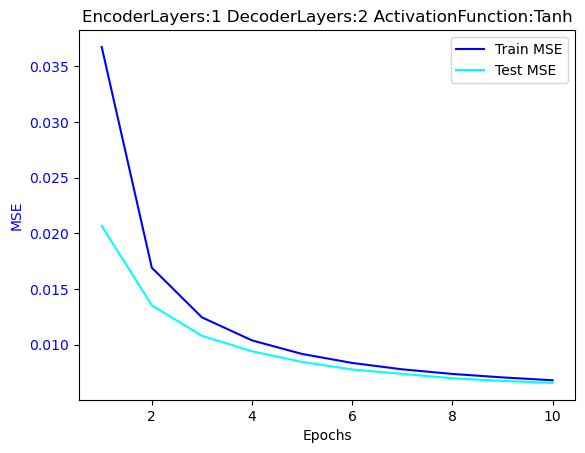

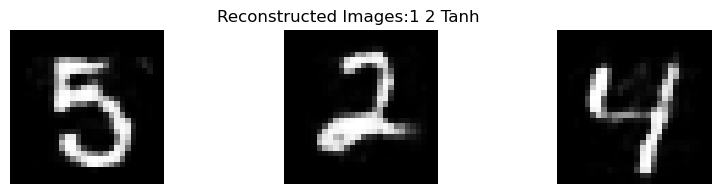

EncoderLayers:1 DecoderLayers:2 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0064,loss_test: 0.0062


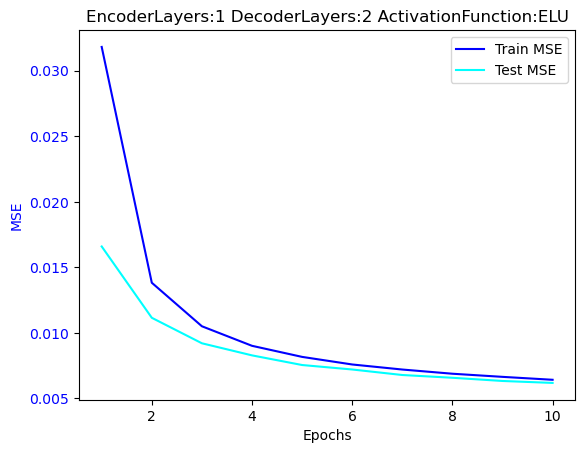

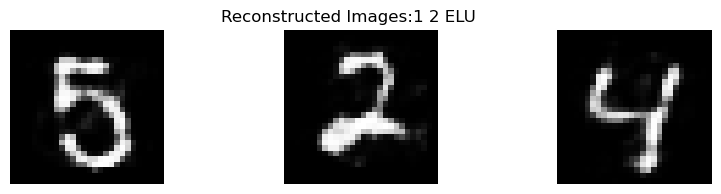

EncoderLayers:1 DecoderLayers:3 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0076,loss_test: 0.0073


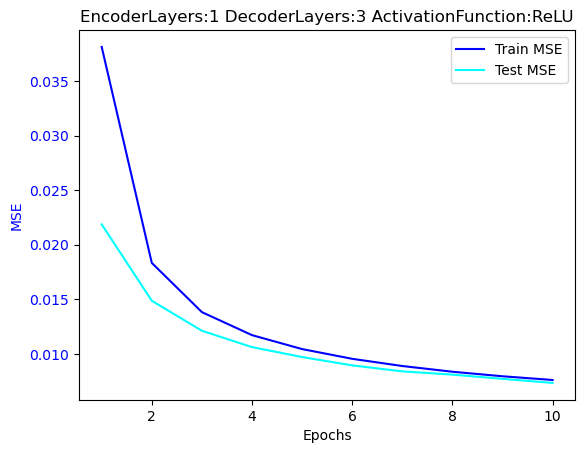

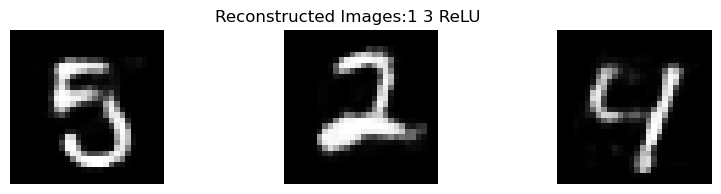

EncoderLayers:1 DecoderLayers:3 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0062,loss_test: 0.0061


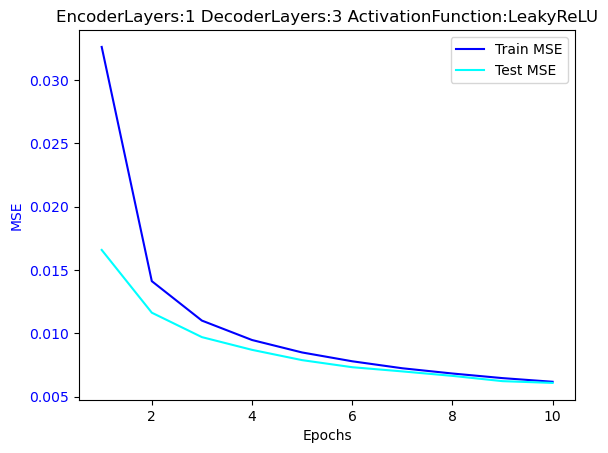

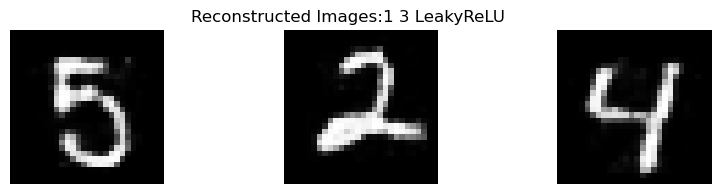

EncoderLayers:1 DecoderLayers:3 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0057,loss_test: 0.0055


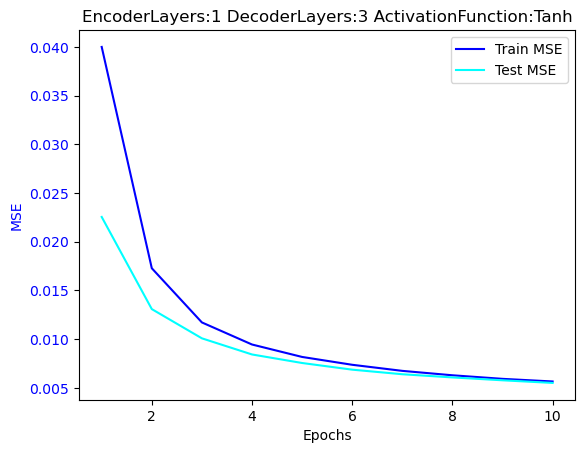

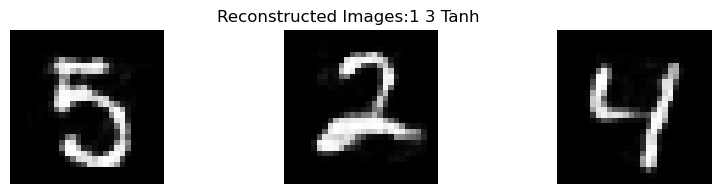

EncoderLayers:1 DecoderLayers:3 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0055,loss_test: 0.0053


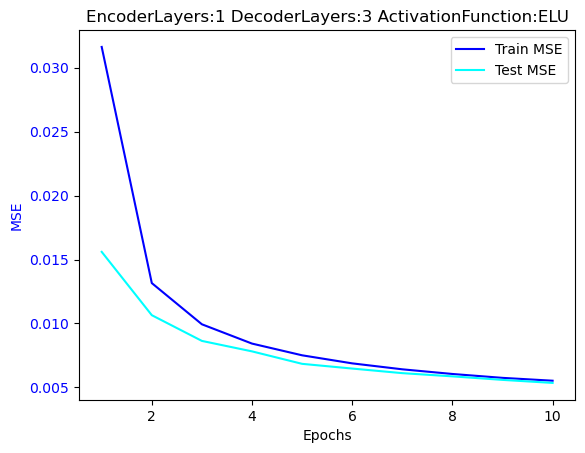

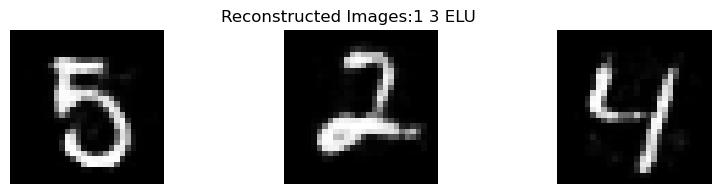

EncoderLayers:1 DecoderLayers:4 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0090,loss_test: 0.0086


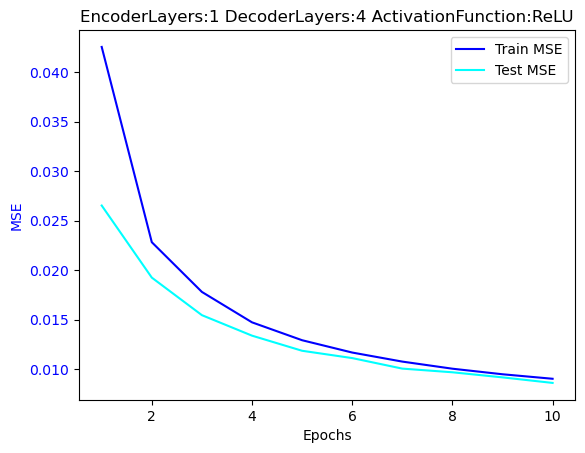

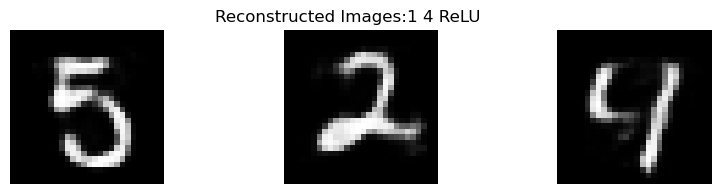

EncoderLayers:1 DecoderLayers:4 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0067,loss_test: 0.0066


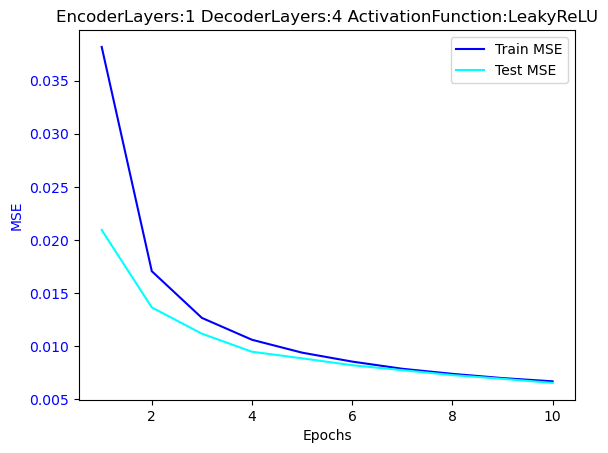

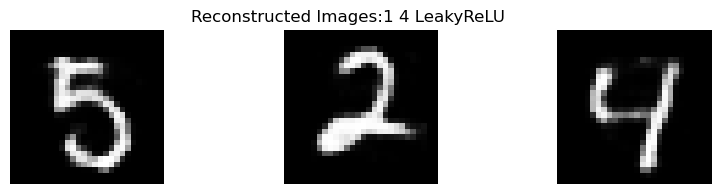

EncoderLayers:1 DecoderLayers:4 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0059,loss_test: 0.0060


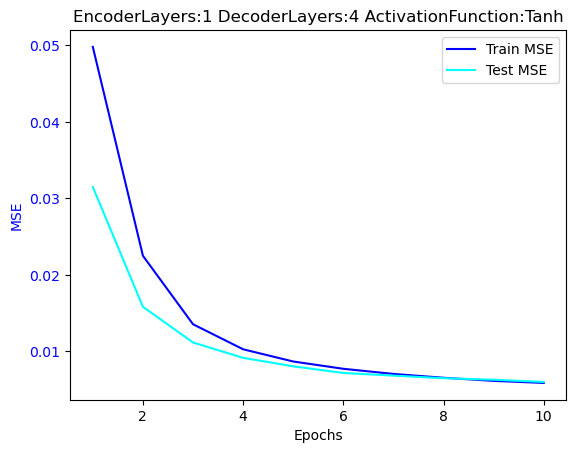

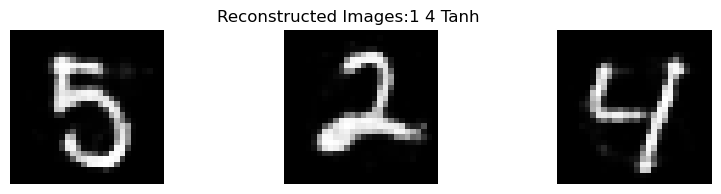

EncoderLayers:1 DecoderLayers:4 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0052,loss_test: 0.0053


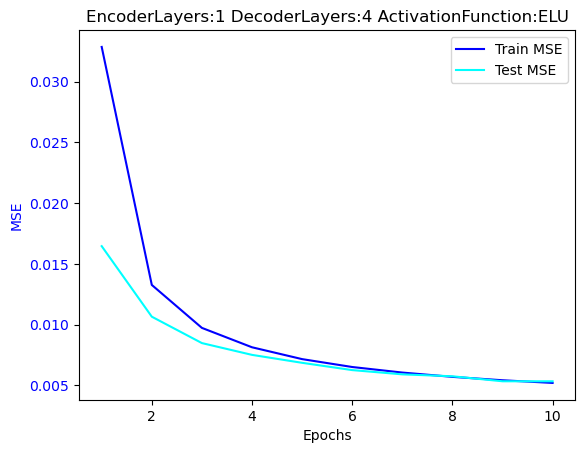

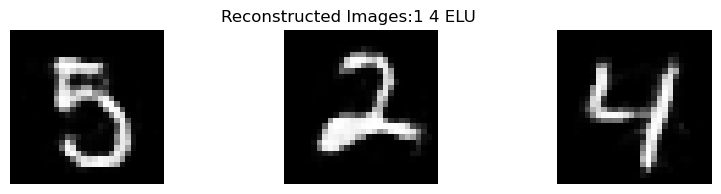

EncoderLayers:1 DecoderLayers:5 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0108,loss_test: 0.0105


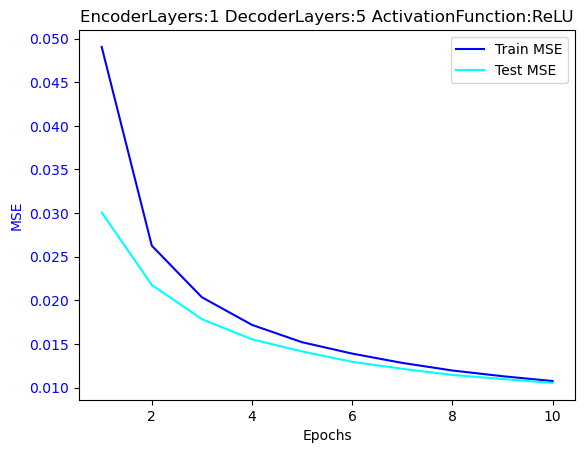

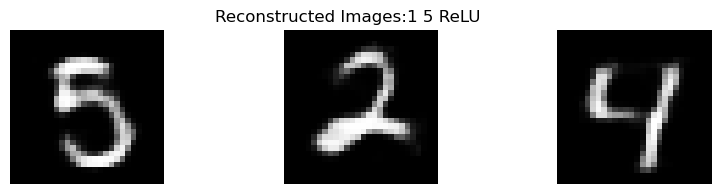

EncoderLayers:1 DecoderLayers:5 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0075,loss_test: 0.0080


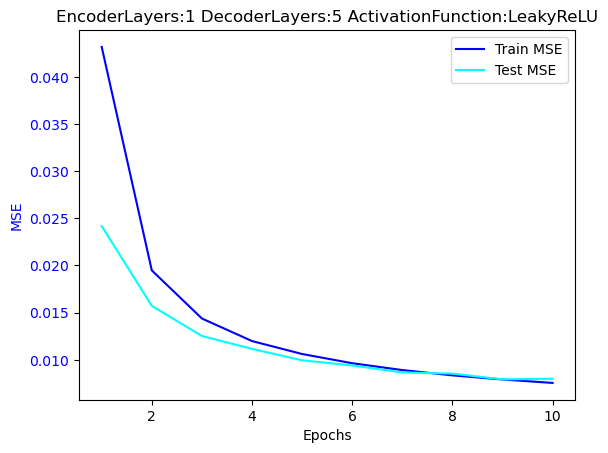

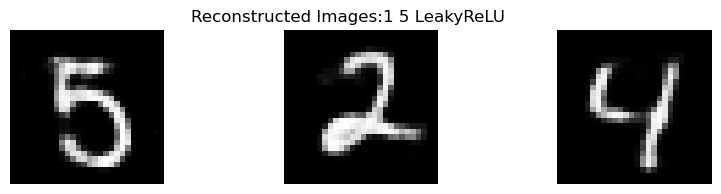

EncoderLayers:1 DecoderLayers:5 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0068,loss_test: 0.0069


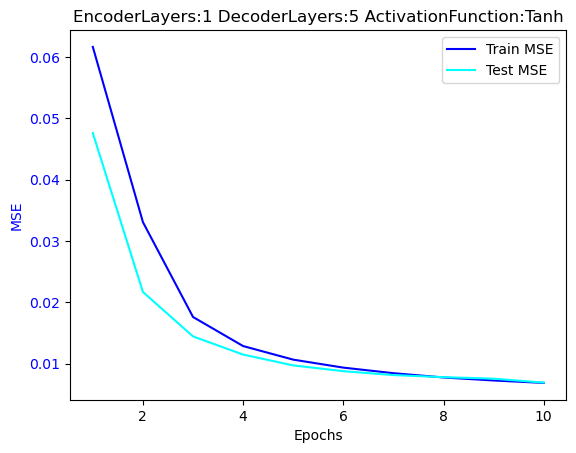

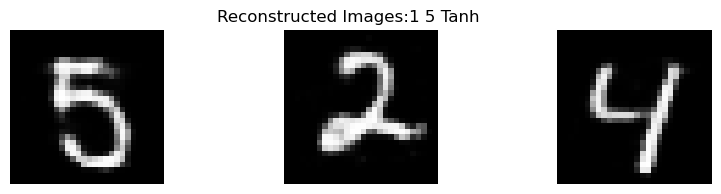

EncoderLayers:1 DecoderLayers:5 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0054,loss_test: 0.0055


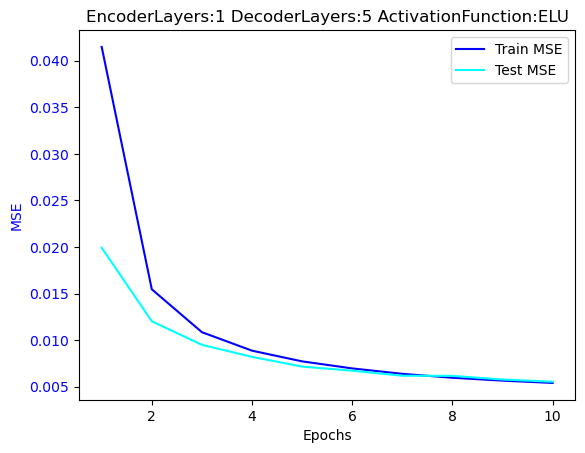

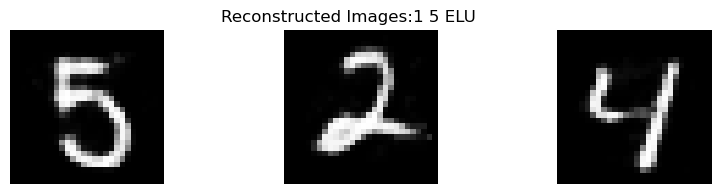

EncoderLayers:2 DecoderLayers:2 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0084,loss_test: 0.0081


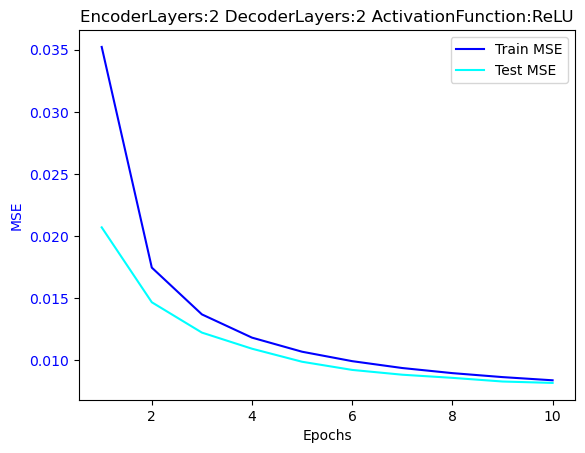

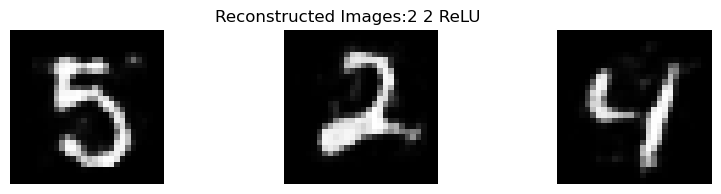

EncoderLayers:2 DecoderLayers:2 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0078,loss_test: 0.0076


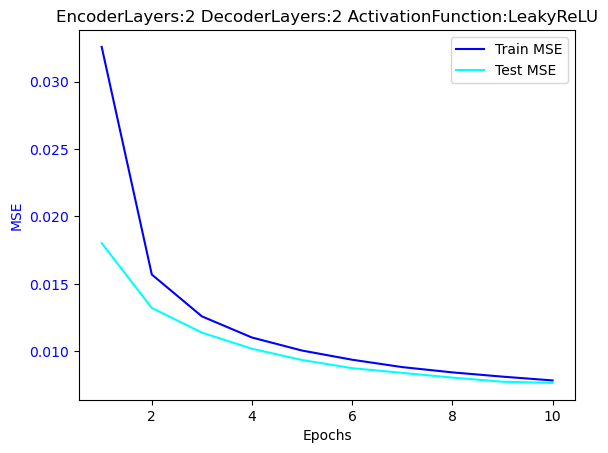

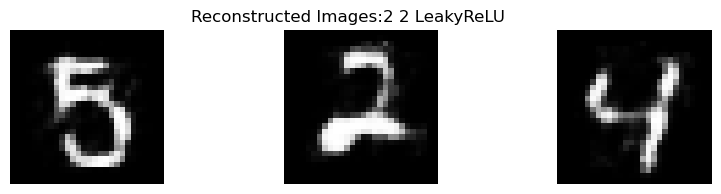

EncoderLayers:2 DecoderLayers:2 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0092,loss_test: 0.0088


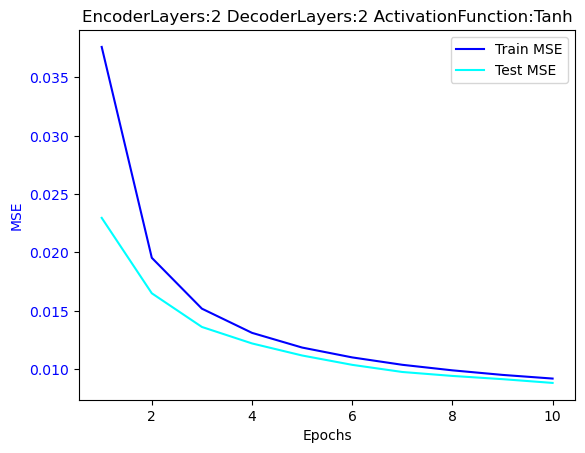

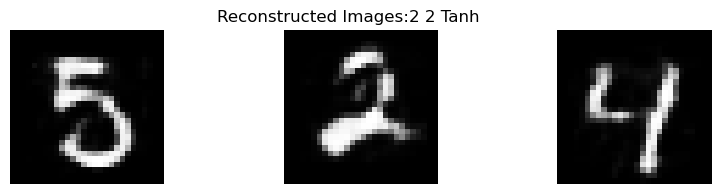

EncoderLayers:2 DecoderLayers:2 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0071,loss_test: 0.0070


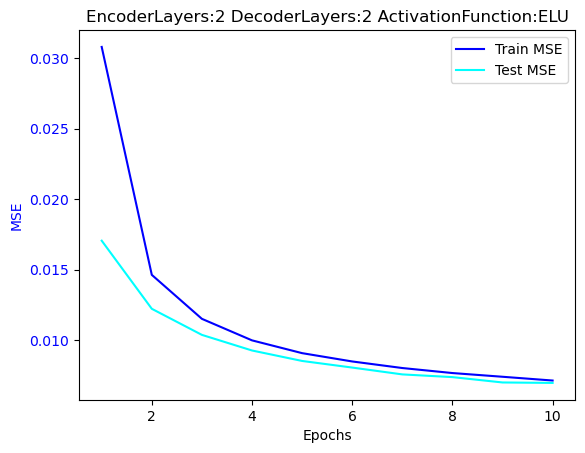

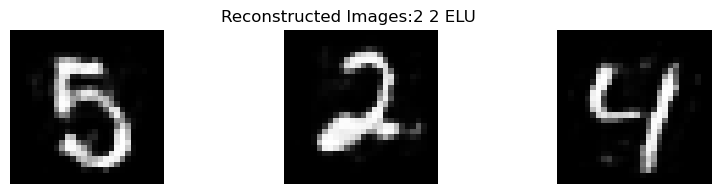

EncoderLayers:2 DecoderLayers:3 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0081,loss_test: 0.0078


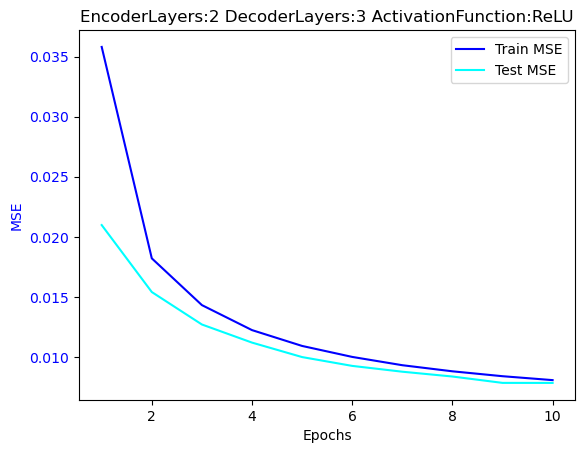

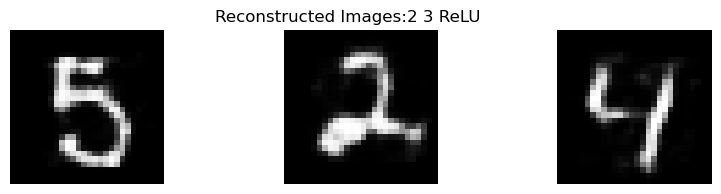

EncoderLayers:2 DecoderLayers:3 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0066,loss_test: 0.0064


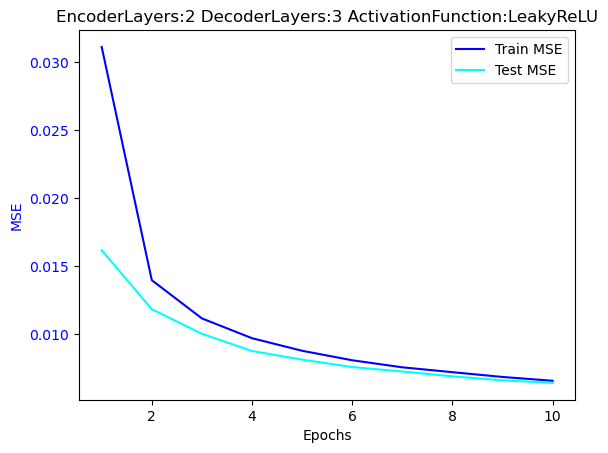

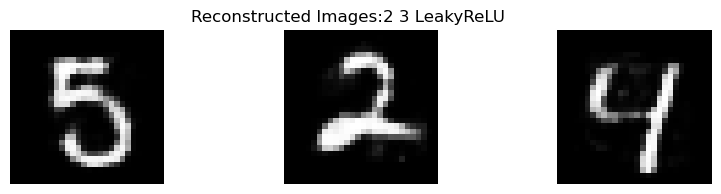

EncoderLayers:2 DecoderLayers:3 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0094,loss_test: 0.0094


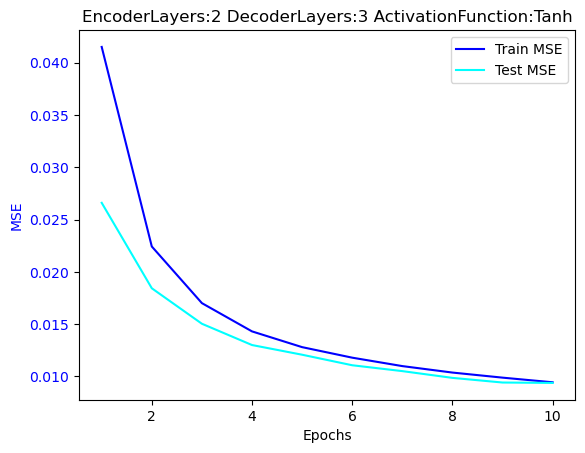

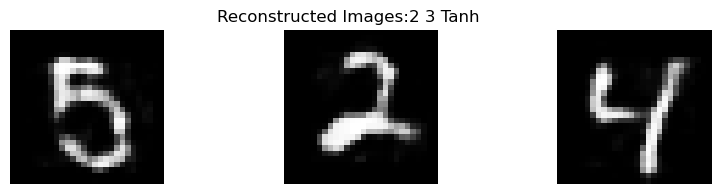

EncoderLayers:2 DecoderLayers:3 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0058,loss_test: 0.0057


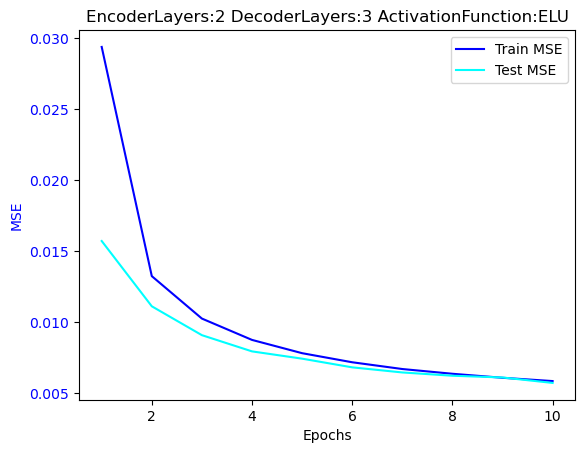

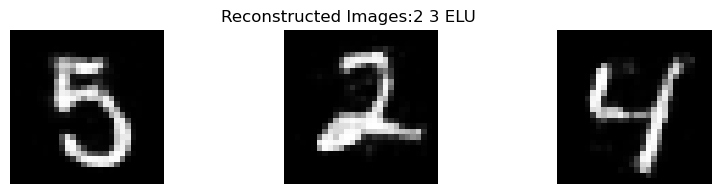

EncoderLayers:2 DecoderLayers:4 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0088,loss_test: 0.0084


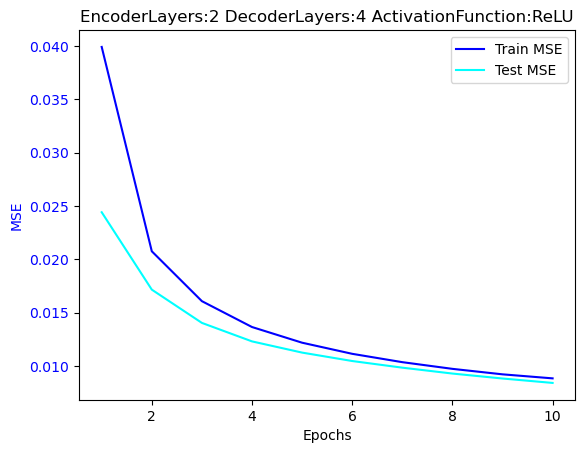

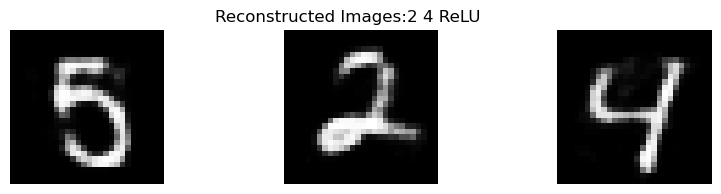

EncoderLayers:2 DecoderLayers:4 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0070,loss_test: 0.0068


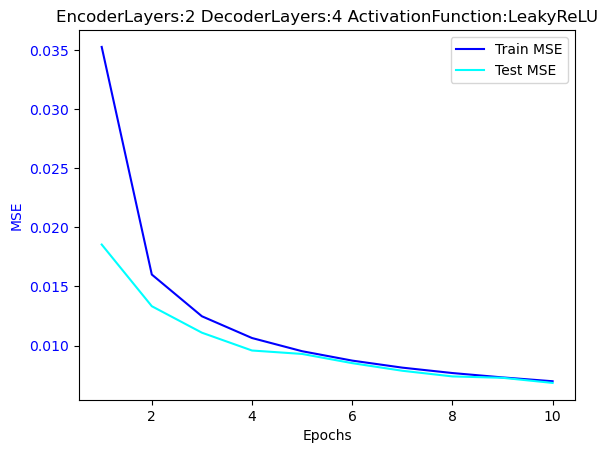

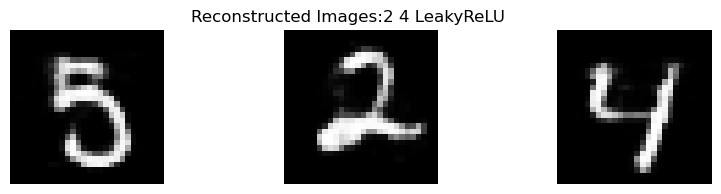

EncoderLayers:2 DecoderLayers:4 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0087,loss_test: 0.0089


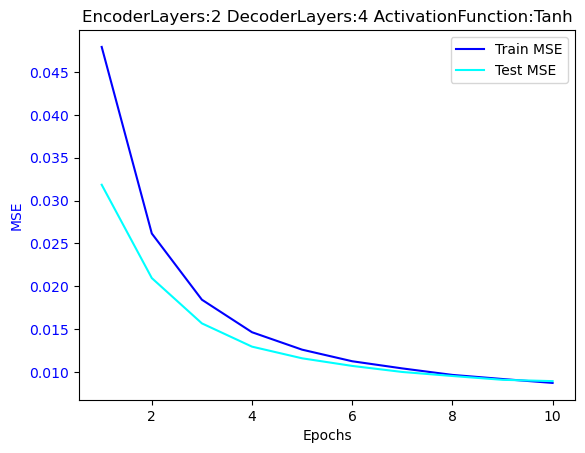

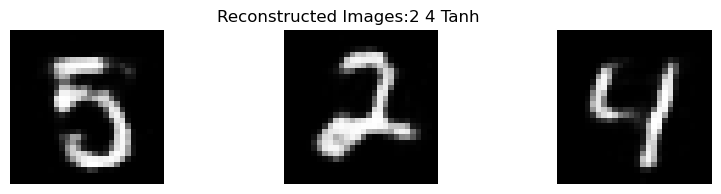

EncoderLayers:2 DecoderLayers:4 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0054,loss_test: 0.0056


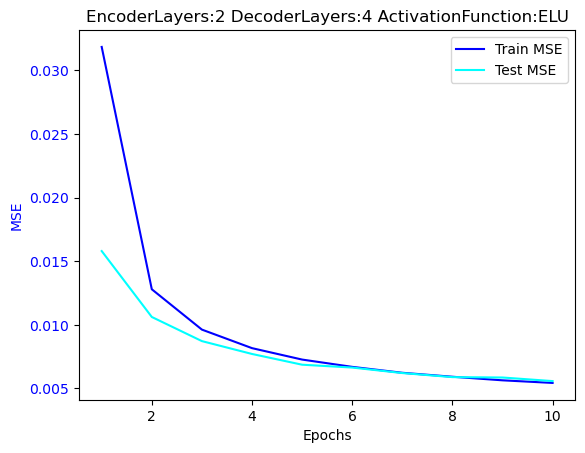

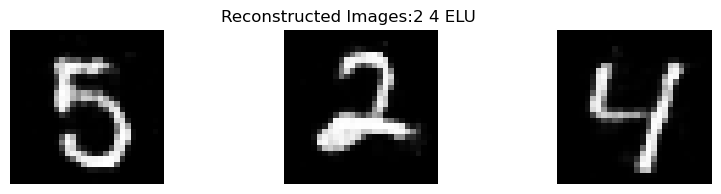

EncoderLayers:2 DecoderLayers:5 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0106,loss_test: 0.0101


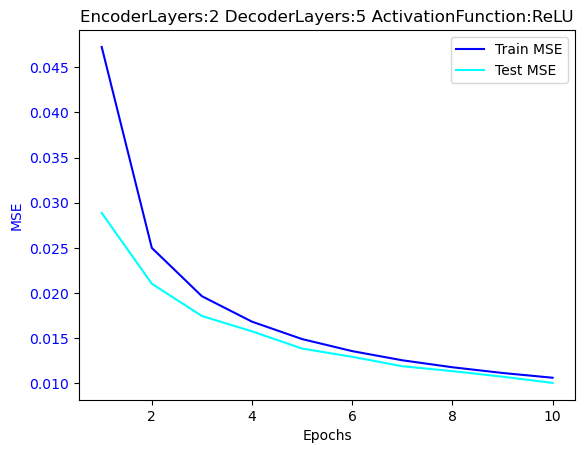

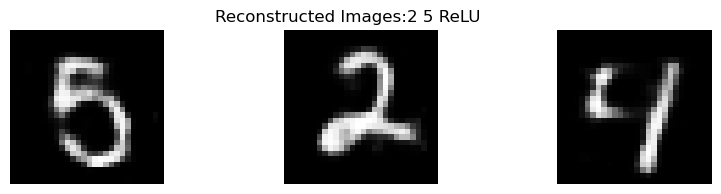

EncoderLayers:2 DecoderLayers:5 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0083,loss_test: 0.0085


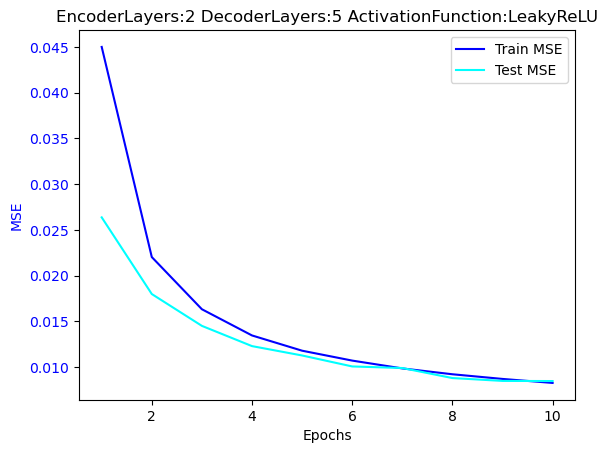

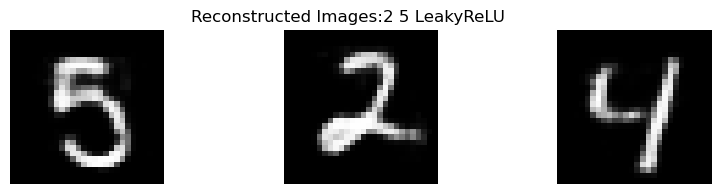

EncoderLayers:2 DecoderLayers:5 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0118,loss_test: 0.0122


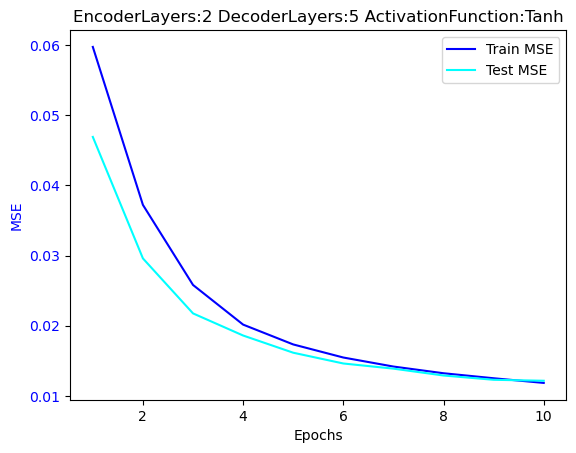

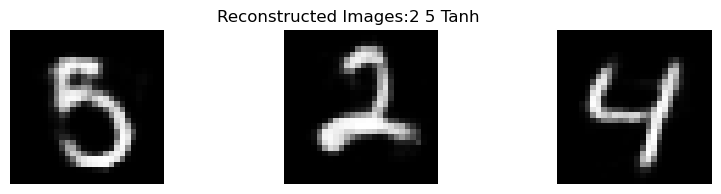

EncoderLayers:2 DecoderLayers:5 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0058,loss_test: 0.0062


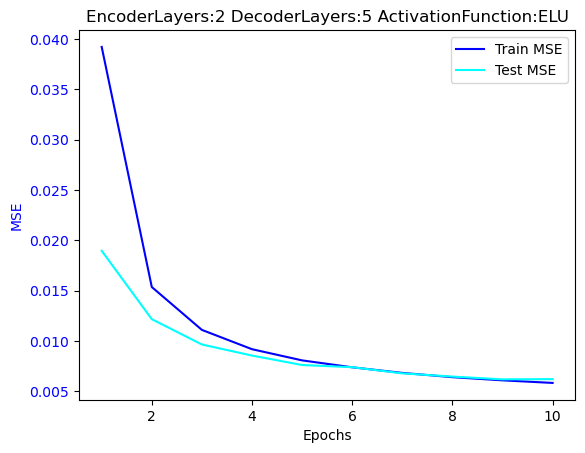

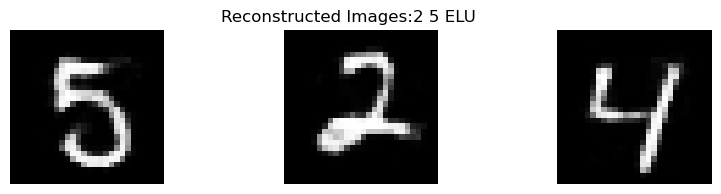

EncoderLayers:3 DecoderLayers:2 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0090,loss_test: 0.0085


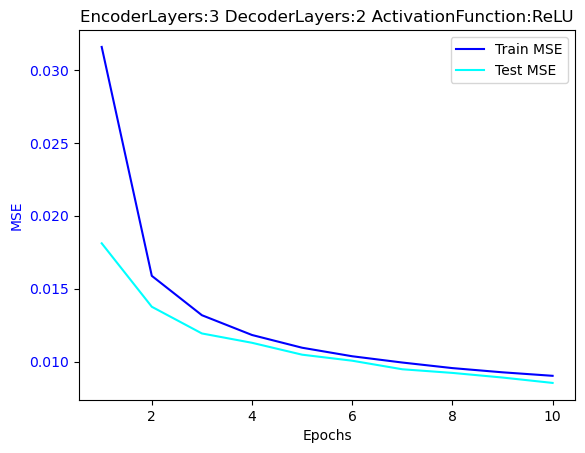

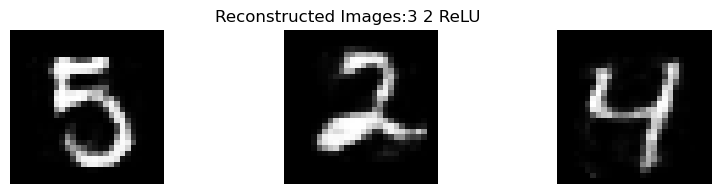

EncoderLayers:3 DecoderLayers:2 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0086,loss_test: 0.0082


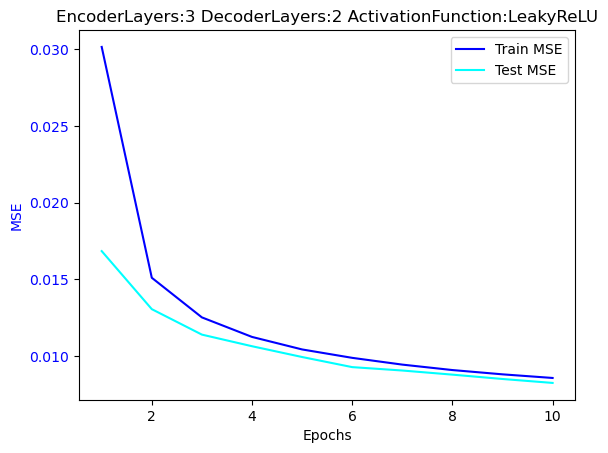

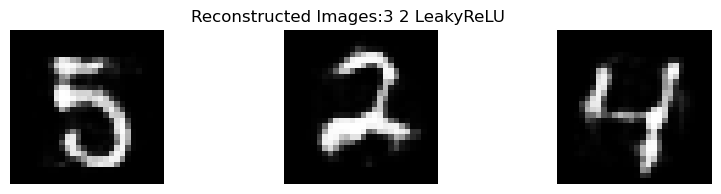

EncoderLayers:3 DecoderLayers:2 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0111,loss_test: 0.0107


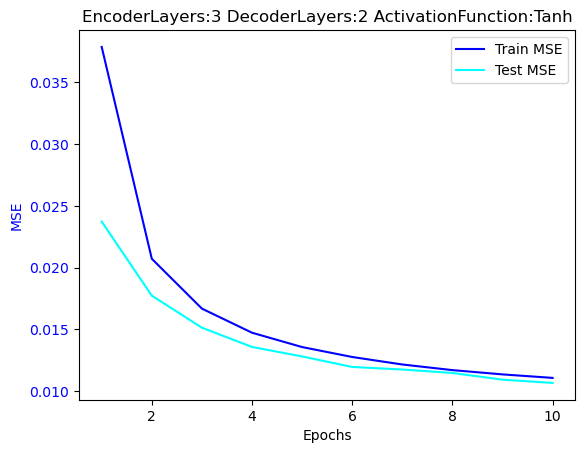

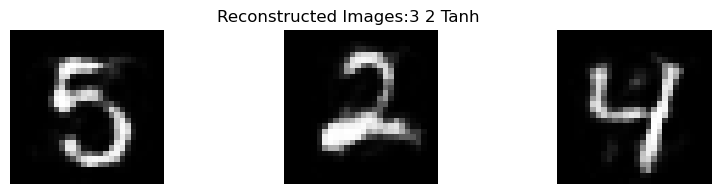

EncoderLayers:3 DecoderLayers:2 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0085,loss_test: 0.0083


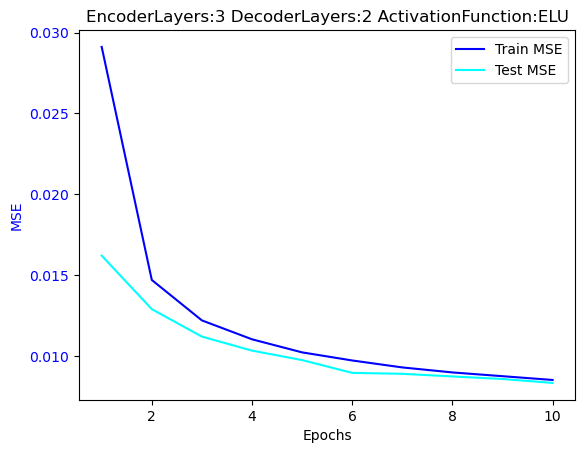

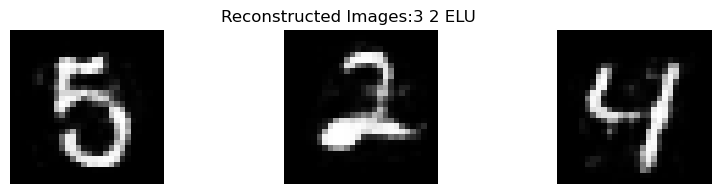

EncoderLayers:3 DecoderLayers:3 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0082,loss_test: 0.0079


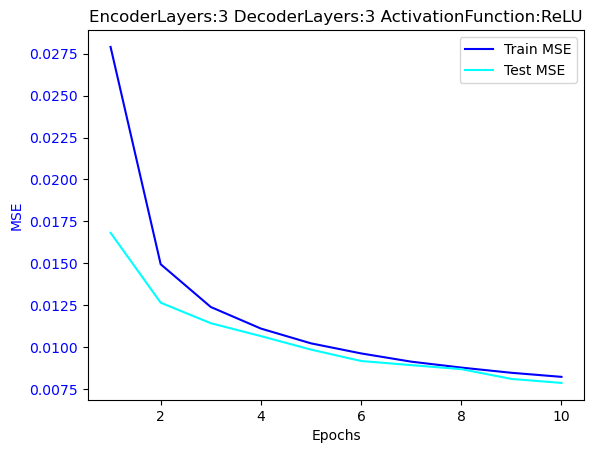

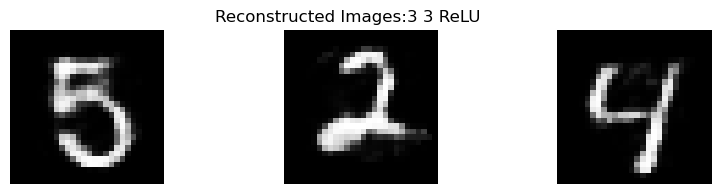

EncoderLayers:3 DecoderLayers:3 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0072,loss_test: 0.0072


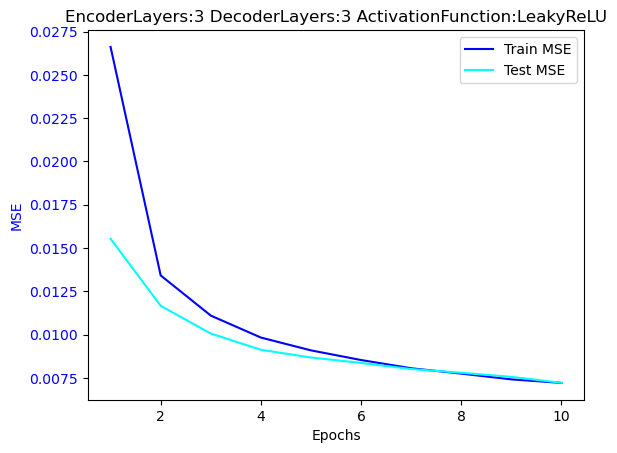

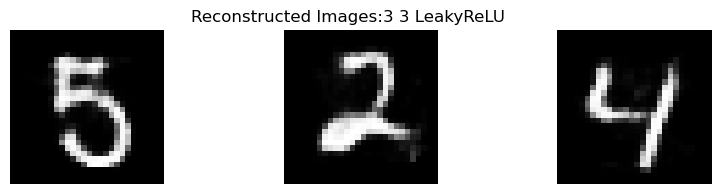

EncoderLayers:3 DecoderLayers:3 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0118,loss_test: 0.0115


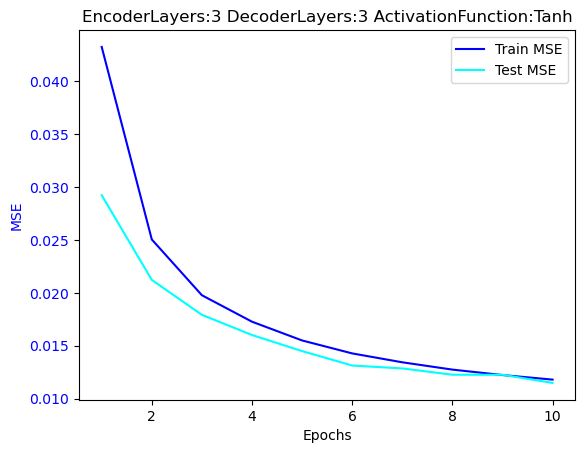

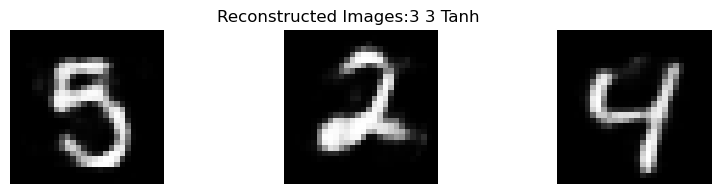

EncoderLayers:3 DecoderLayers:3 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0066,loss_test: 0.0069


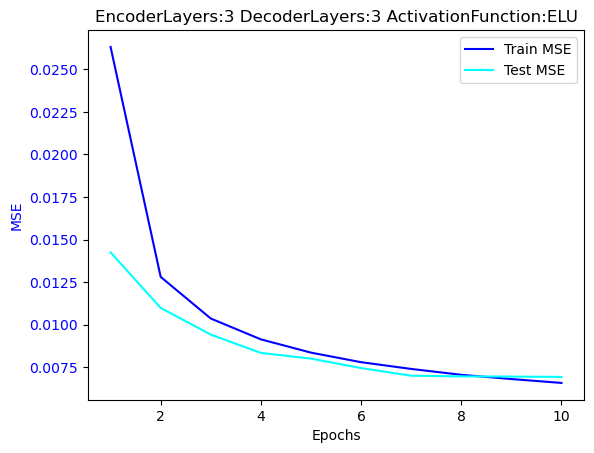

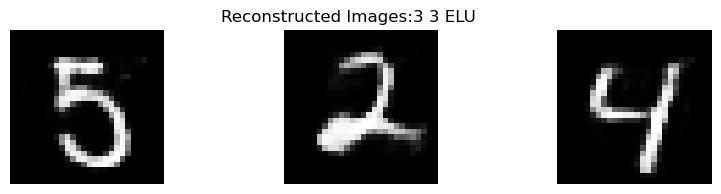

EncoderLayers:3 DecoderLayers:4 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0088,loss_test: 0.0085


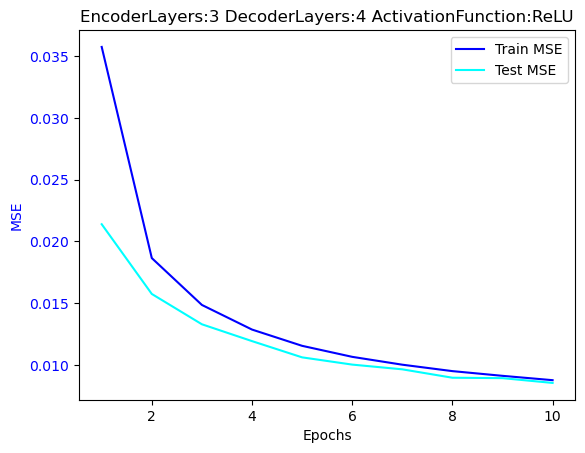

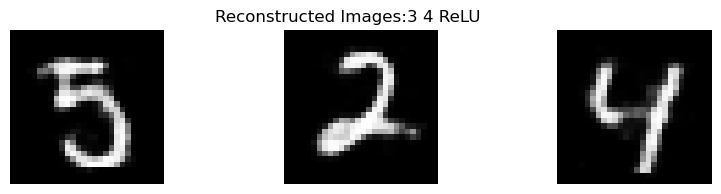

EncoderLayers:3 DecoderLayers:4 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0070,loss_test: 0.0073


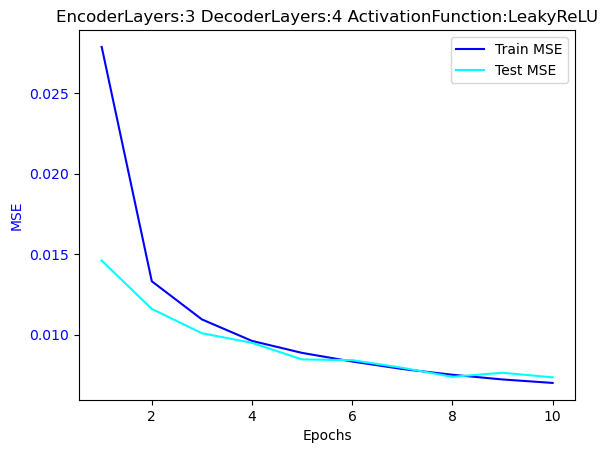

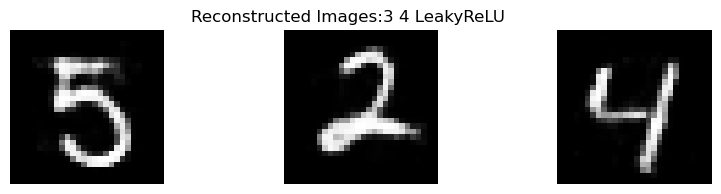

EncoderLayers:3 DecoderLayers:4 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0145,loss_test: 0.0143


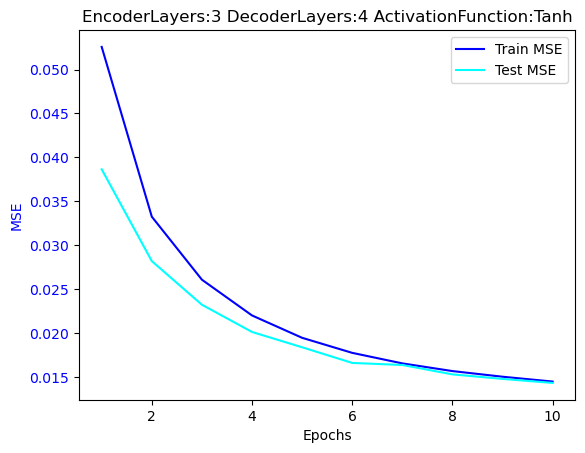

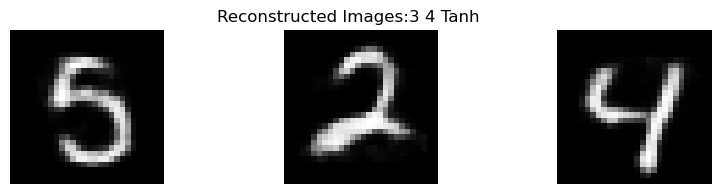

EncoderLayers:3 DecoderLayers:4 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0063,loss_test: 0.0064


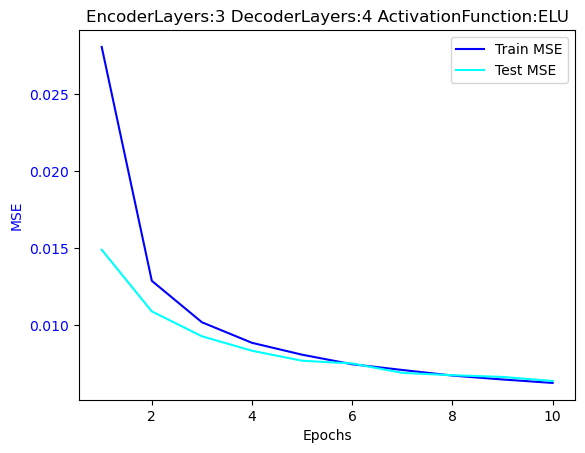

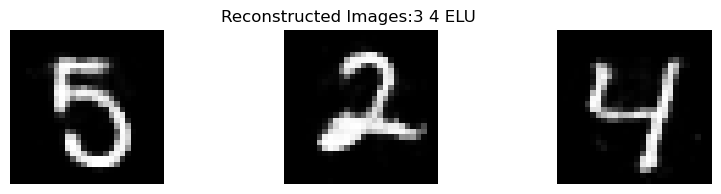

EncoderLayers:3 DecoderLayers:5 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0103,loss_test: 0.0103


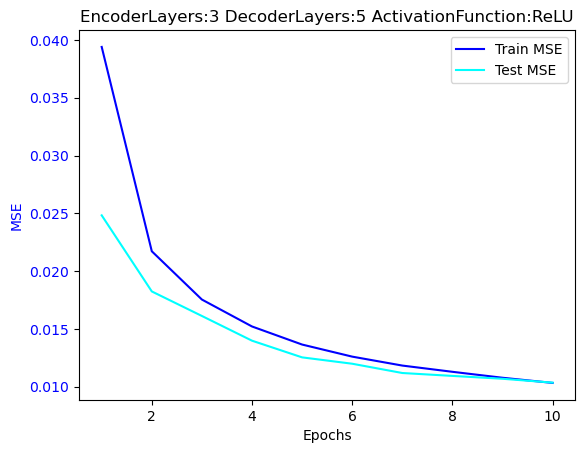

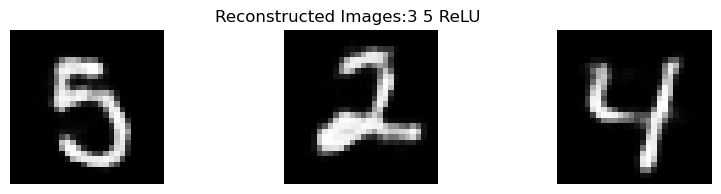

EncoderLayers:3 DecoderLayers:5 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0079,loss_test: 0.0081


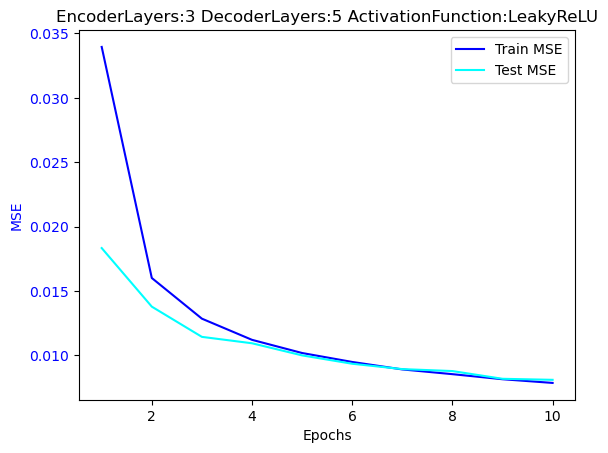

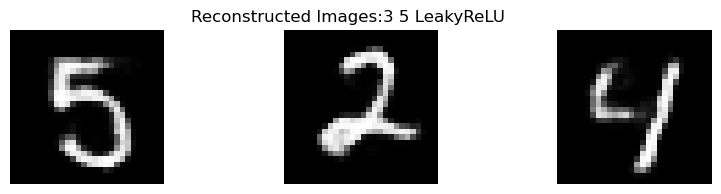

EncoderLayers:3 DecoderLayers:5 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0154,loss_test: 0.0156


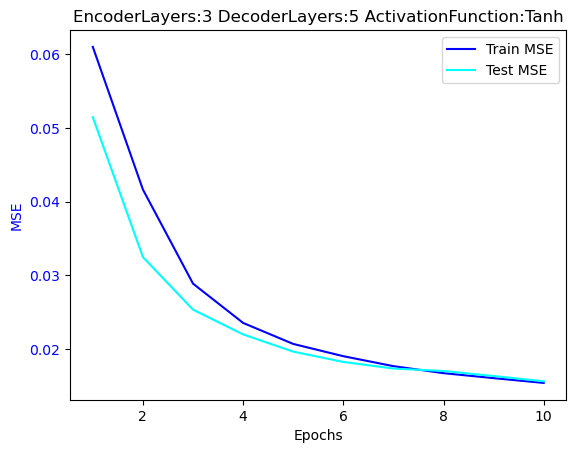

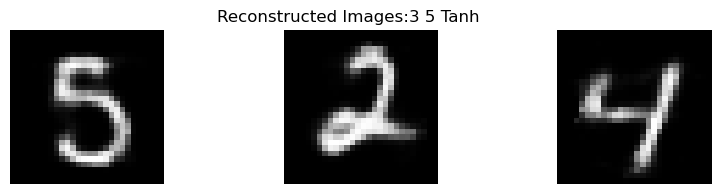

EncoderLayers:3 DecoderLayers:5 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0064,loss_test: 0.0066


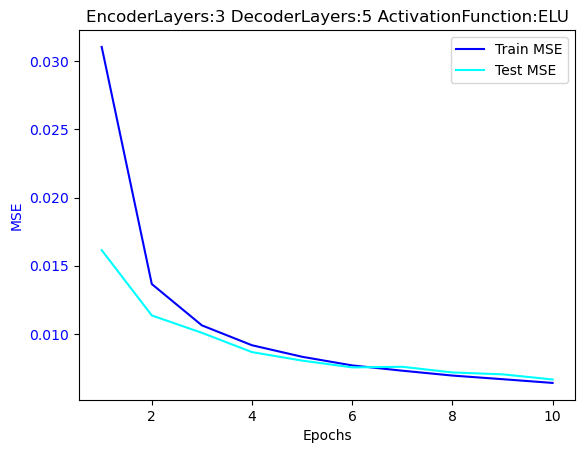

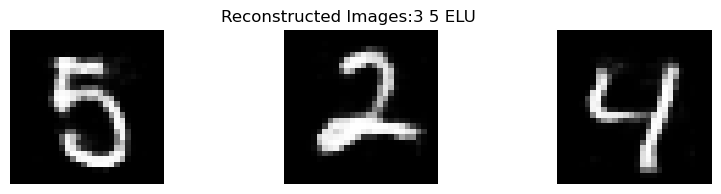

EncoderLayers:4 DecoderLayers:2 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0135,loss_test: 0.0131


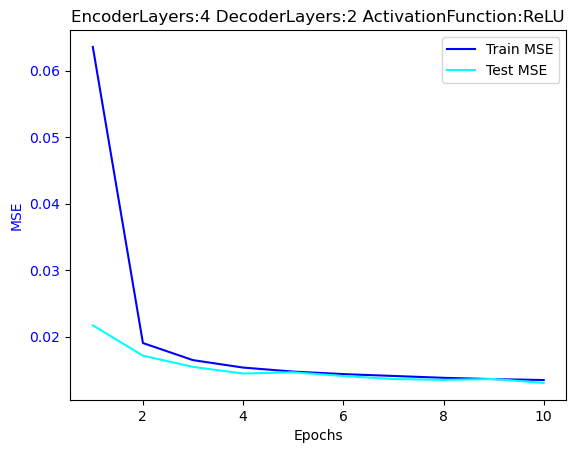

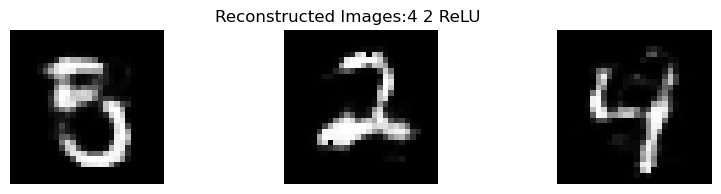

EncoderLayers:4 DecoderLayers:2 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0120,loss_test: 0.0119


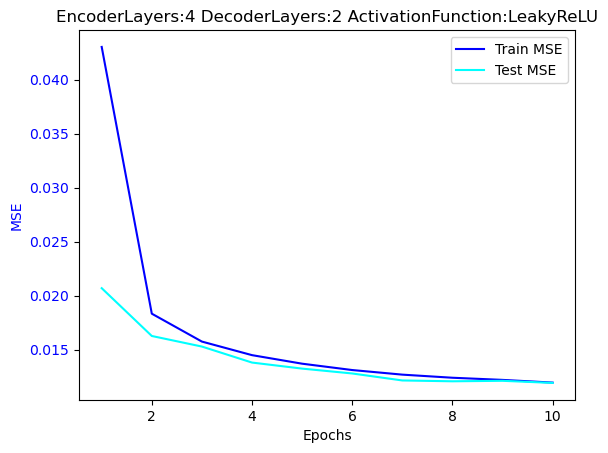

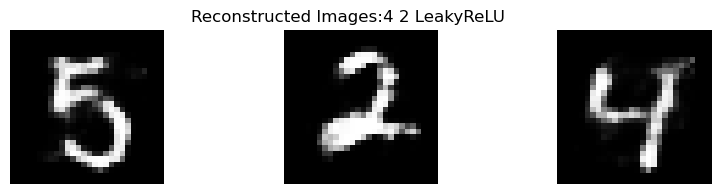

EncoderLayers:4 DecoderLayers:2 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0168,loss_test: 0.0164


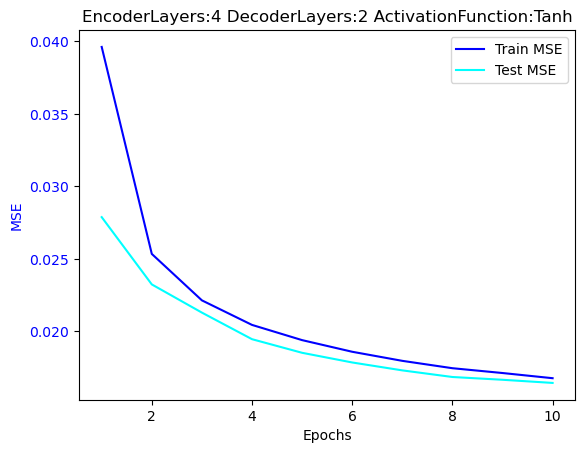

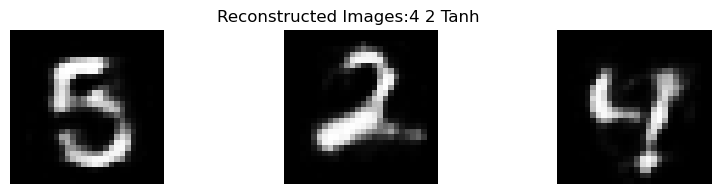

EncoderLayers:4 DecoderLayers:2 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0112,loss_test: 0.0112


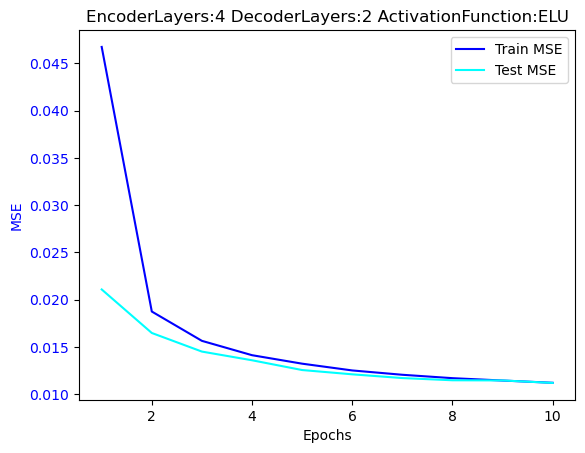

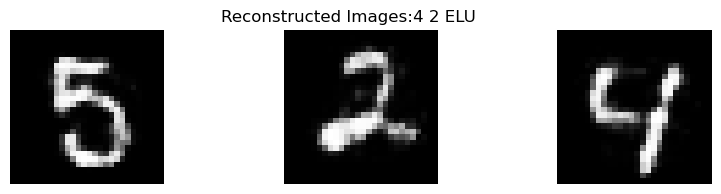

EncoderLayers:4 DecoderLayers:3 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0090,loss_test: 0.0087


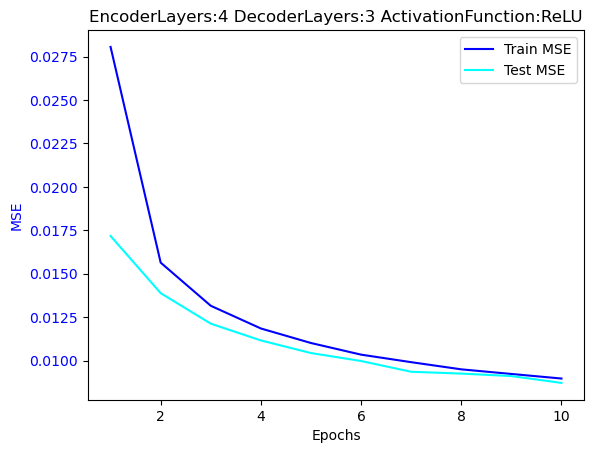

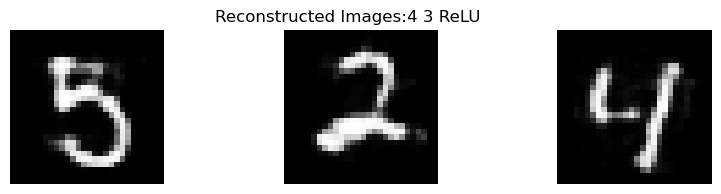

EncoderLayers:4 DecoderLayers:3 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0114,loss_test: 0.0116


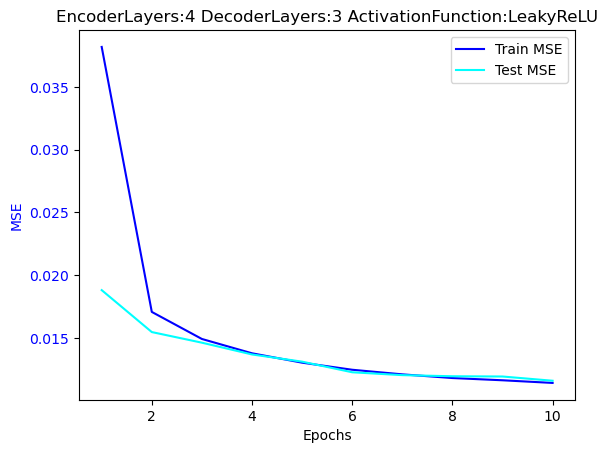

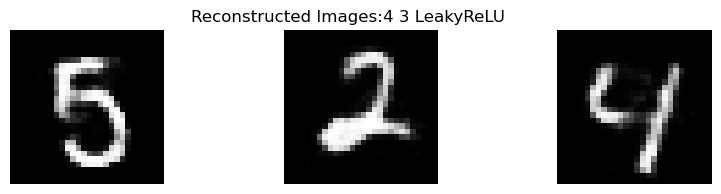

EncoderLayers:4 DecoderLayers:3 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0233,loss_test: 0.0229


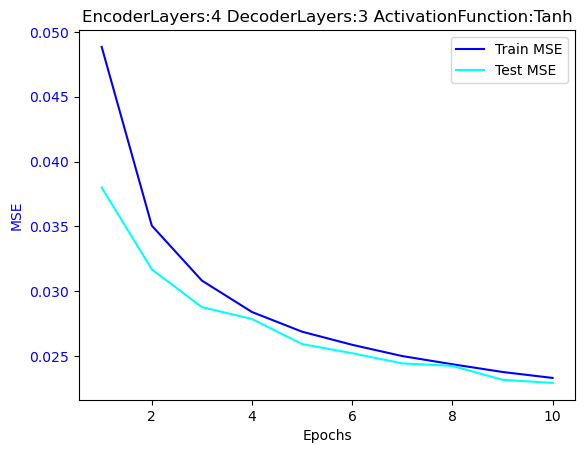

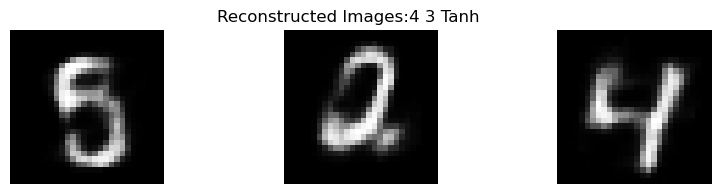

EncoderLayers:4 DecoderLayers:3 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0088,loss_test: 0.0091


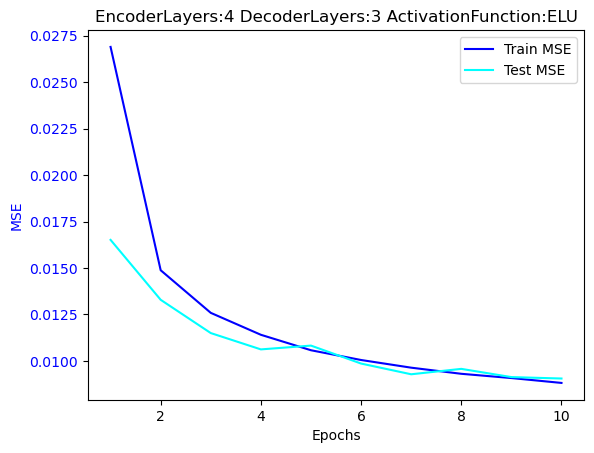

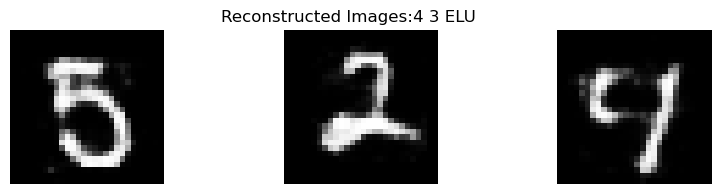

EncoderLayers:4 DecoderLayers:4 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0104,loss_test: 0.0107


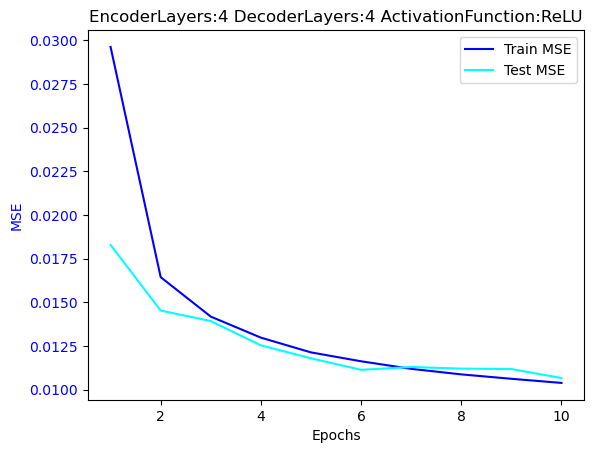

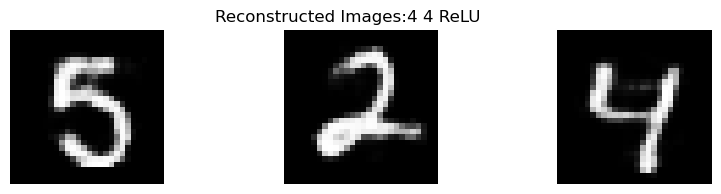

EncoderLayers:4 DecoderLayers:4 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0101,loss_test: 0.0106


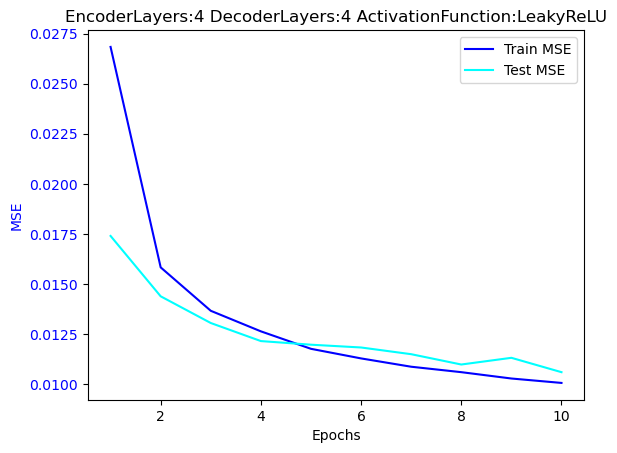

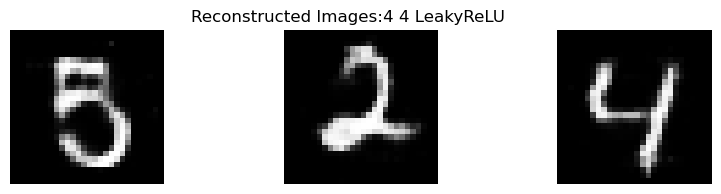

EncoderLayers:4 DecoderLayers:4 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0303,loss_test: 0.0298


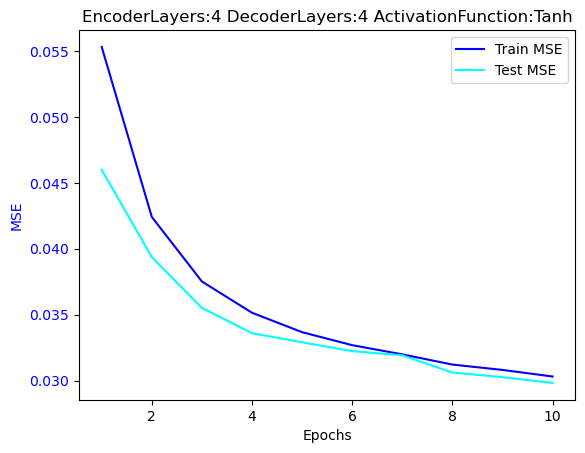

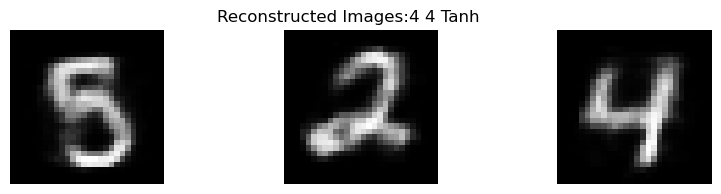

EncoderLayers:4 DecoderLayers:4 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0094,loss_test: 0.0100


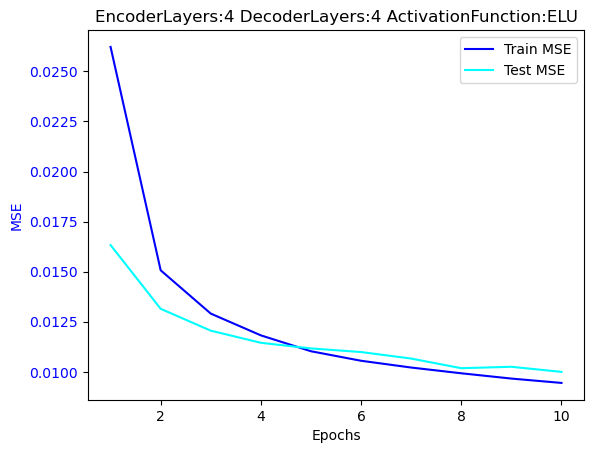

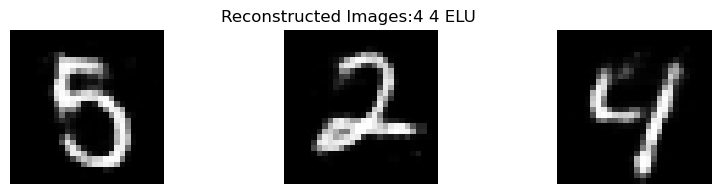

EncoderLayers:4 DecoderLayers:5 ActivationFunction:ReLU Epoch: 9/10

loss_train: 0.0106,loss_test: 0.0106


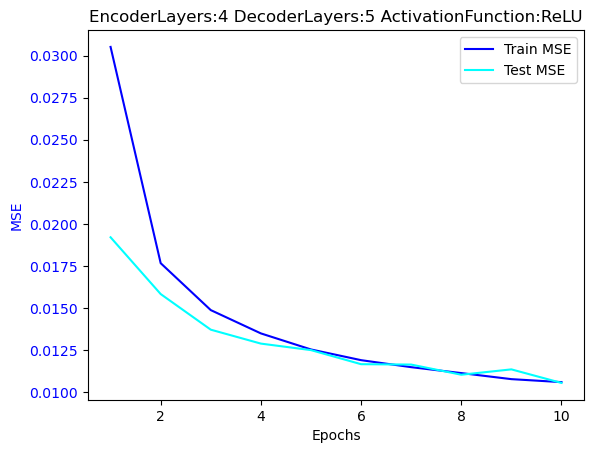

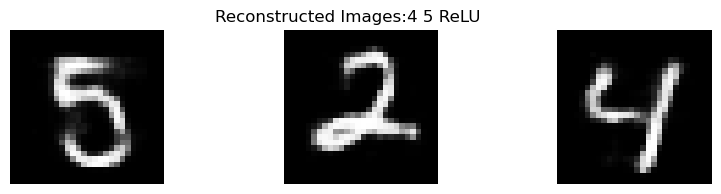

EncoderLayers:4 DecoderLayers:5 ActivationFunction:LeakyReLU Epoch: 9/10

loss_train: 0.0100,loss_test: 0.0107


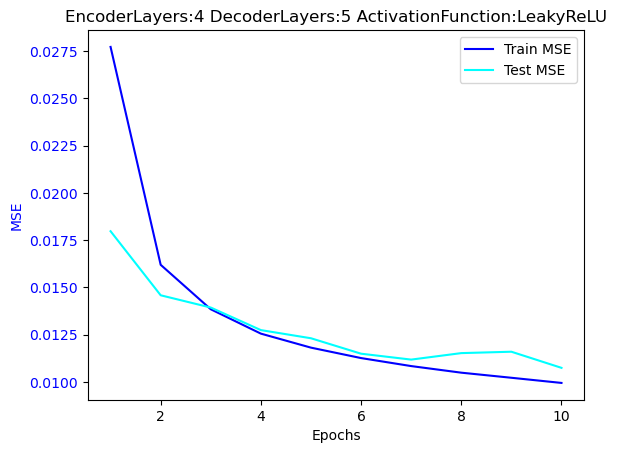

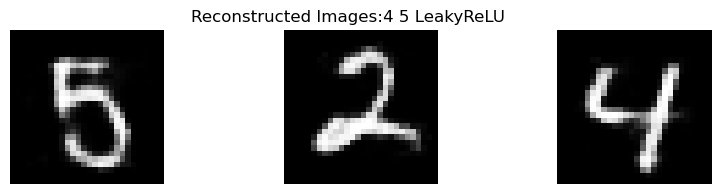

EncoderLayers:4 DecoderLayers:5 ActivationFunction:Tanh Epoch: 9/10

loss_train: 0.0515,loss_test: 0.0552


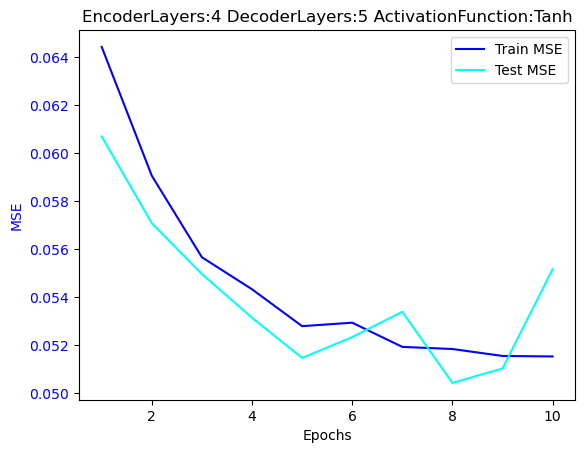

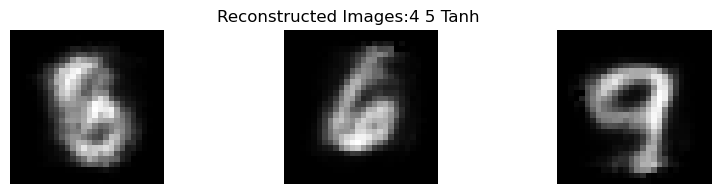

EncoderLayers:4 DecoderLayers:5 ActivationFunction:ELU Epoch: 9/10

loss_train: 0.0091,loss_test: 0.0101


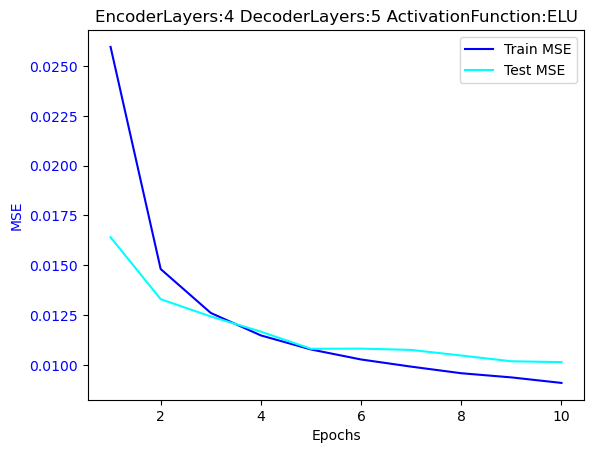

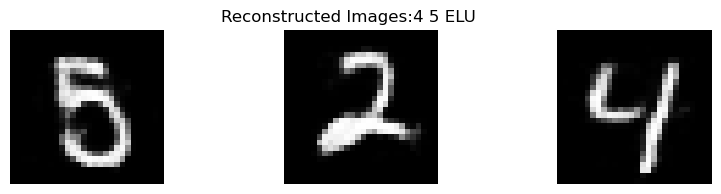

In [12]:
All_loss_train = []
All_loss_test = []
All_pro_time = []
results = []

DofIN = 784
DofOUT = 784
num_N = 128

max_epochs = 10##

for En_lay in range(1,5): #(1,5)

    for De_lay in range(2,6): #(2,6)

        for act_fun in range(1,5): #(1,5)

            act_fun_dict = {
            1: 'ReLU',
            2: 'LeakyReLU',
            3: 'Tanh',
            4: 'ELU'
            }
            sel_act_fun = act_fun_dict.get(act_fun, 'ReLU')

            model = AutoEncoder(DofIN,num_N,En_lay,De_lay,act_fun).to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            loss_train_ = []
            loss_test_ = []
            pro_time_ = []
            result={}

            
            for epoch in range(max_epochs):

                sys.stderr.write('\rEncoderLayers:%d DecoderLayers:%d ActivationFunction:%s Epoch: %d/%d' % (En_lay, De_lay,sel_act_fun, epoch, max_epochs)) 
                sys.stderr.flush()

                loss_train = 0
                loss_test = 0

                start_time1 = time.time()
                for (x,t) in train_dataloader:
                    
                    x, t = x.to(device), t.to(device)
                    y = model(x)
                    loss = criterion(y, x.view(x.size(0), -1)) 
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    loss_train += loss.item()
       
                loss_train_avg = loss_train / len(train_dataloader)
                end_time1 = time.time()
                pro_time_.append(end_time1-start_time1)


                with torch.no_grad():
                    for x, t in test_dataloader:
                        x, t = x.to(device), t.to(device)
                        y = model(x)
                        loss = criterion(y, x.view(x.size(0), -1))
        
                        loss_test += loss.item()

                loss_test_avg = loss_test / len(test_dataloader)

                loss_train_.append(loss_train_avg)
                loss_test_.append(loss_test_avg)
        
                if epoch == max_epochs-1:
                    All_loss_train.append(loss_train_avg)
                    All_loss_test.append(loss_test_avg)
                    All_pro_time.append(sum(pro_time_))   
        
            print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")

            Last_loss_test = loss_test_[-1]
            result = {"EncoderLayers":En_lay, "DecoderLayers":De_lay, "ActivationFunction":sel_act_fun, "MSE":Last_loss_test,"ProcessingTime":sum(pro_time_)}
            results.append(result)

            fig, ax1 = plt.subplots()
            ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
            ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('MSE', color = 'blue')
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.set_ylim(0,0.045)
            ax1.legend()

            title = 'EncoderLayers:%d DecoderLayers:%d ActivationFunction:%s'%(En_lay,De_lay,sel_act_fun) #
            plt.title(title)
            file_name = '%d_LOSS%d_%d_%s.png'%(int(formatted_date),En_lay,De_lay,sel_act_fun)
            full_path = os.path.join(save_directory, file_name)
            plt.savefig(full_path, dpi=100, bbox_inches='tight')
            plt.show()

            with torch.no_grad():
                test_images = test_images.to(device)
                reconstructed_images = model(test_images)
                image_title = 'Reconstructed Images:%d %d %s'%(En_lay,De_lay,sel_act_fun)
                show_images(reconstructed_images.cpu(),test_labels, image_title)
                file_name = '%d_ReImage%d_%d_%s.png'%(int(formatted_date),En_lay,De_lay,sel_act_fun)
                full_path = os.path.join(save_directory, file_name)
                plt.savefig(full_path, dpi=100, bbox_inches='tight')
                plt.show()


df_results = pd.DataFrame(results)




In [13]:
print(df_results)

file_name = '%d_AE[9]_exResults.csv'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
df_results.to_csv(full_path, index=False)

    EncoderLayers  DecoderLayers ActivationFunction       MSE  ProcessingTime
0               1              2               ReLU  0.007004       40.791604
1               1              2          LeakyReLU  0.006745       40.326261
2               1              2               Tanh  0.006560       40.232184
3               1              2                ELU  0.006176       39.790176
4               1              3               ReLU  0.007332       44.512978
..            ...            ...                ...       ...             ...
59              4              4                ELU  0.009997       70.046096
60              4              5               ReLU  0.010558       73.916290
61              4              5          LeakyReLU  0.010748       72.841234
62              4              5               Tanh  0.055170       75.540035
63              4              5                ELU  0.010133       77.172653

[64 rows x 5 columns]


In [14]:
min_MSE_test = np.min(All_loss_test)

min_index_test = All_loss_test.index(min_MSE_test)
best_result = results[min_index_test]

print(min_MSE_test)
print('Test Min:EncoderLayers:%d DecoderLayers:%d ActivationFunction:%s MSE=%.4f'%(best_result['EncoderLayers'],best_result['DecoderLayers'],best_result['ActivationFunction'],best_result['MSE']))

0.005325236534699798
Test Min:EncoderLayers:1 DecoderLayers:4 ActivationFunction:ELU MSE=0.0053


In [15]:
'''
import csv
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data','texts') 
print(save_directory)
os.makedirs(save_directory, exist_ok=True)
file_name = 'AE[8]_list.csv'##
full_path = os.path.join(save_directory, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(All_loss_train)
    writer.writerow(All_loss_test)
    '''

"\nimport csv\nsave_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data','texts') \nprint(save_directory)\nos.makedirs(save_directory, exist_ok=True)\nfile_name = 'AE[8]_list.csv'##\nfull_path = os.path.join(save_directory, file_name)\nwith open(full_path, mode='w', newline='') as file:\n    writer = csv.writer(file)\n    writer.writerow(All_loss_train)\n    writer.writerow(All_loss_test)\n    "